In [5]:
from graph_cnn.model import create_model
from graph_cnn.graph import create_final_graph,cross_over
import networkx as nx
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import clear_output

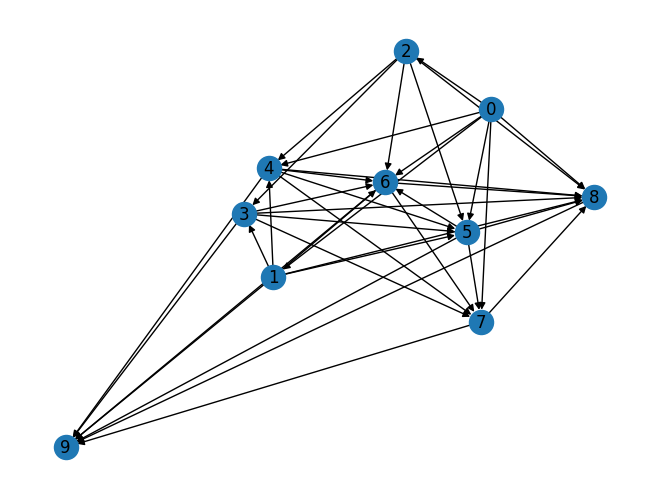

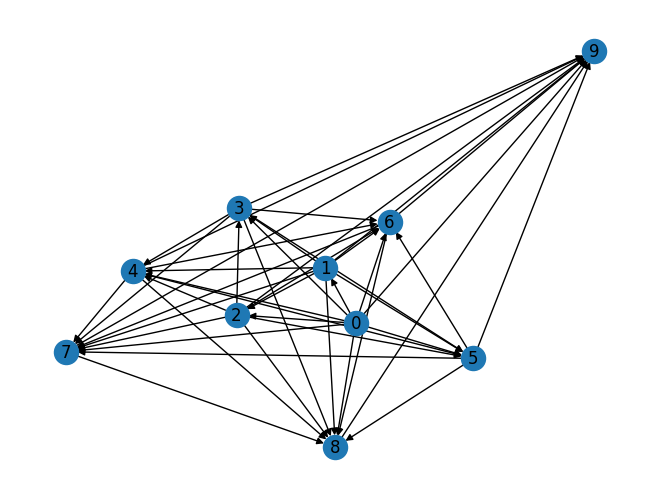

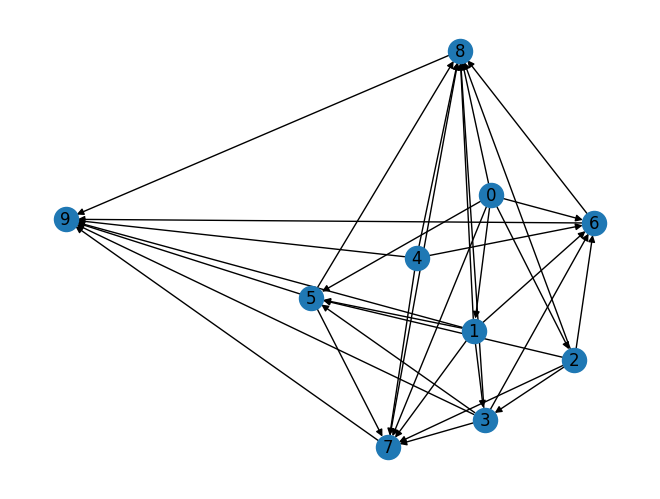

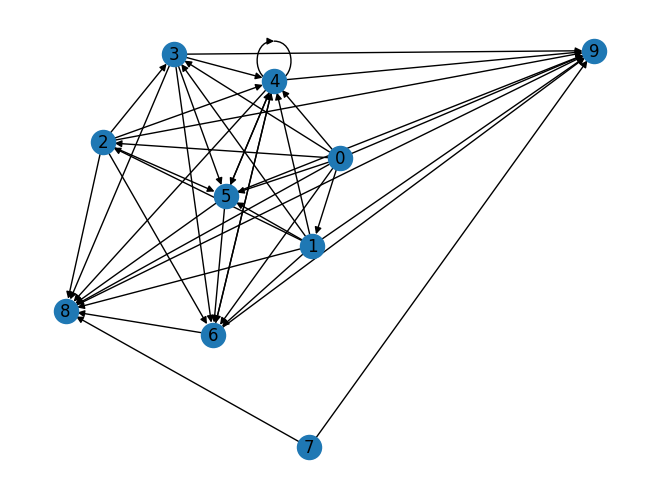

2
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 28, 28, 32)           1600      ['input_3[0][0]']             
                                                                                                  
 dropout_10 (Dropout)        (None, 28, 28, 32)           0         ['conv2d_17[0][0]']           
                                                                                                  
 conv2d_18 (Conv2D)          (None, 28, 28, 64)           18496     ['dropout_10[0][0]']          
                                                                                          

In [6]:
graph_ = create_final_graph(10,0.7)
graph2 = create_final_graph(10,1.0)
nx.draw(graph_,with_labels=True)
plt.show()
nx.draw(graph2,with_labels=True)
plt.show()
graph,graph1 = cross_over(graph_,graph2)
nx.draw(graph,with_labels=True)
plt.show()
nx.draw(graph1,with_labels=True)
plt.show()
model = create_model(graph_,input_shape=(28,28,1))
model.summary()

In [7]:
train_dataset, info = tfds.load('mnist', split='train', with_info=True, as_supervised=True)
test_dataset = tfds.load('mnist', split='test', as_supervised=True)

# Print dataset information
print(info)

train_dataset = train_dataset.cache().shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/balasai/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [8]:
model2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(28,28,1)),
        #tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.GaussianNoise(0.3),
        tf.keras.layers.Rescaling(1/.255),
        model,
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='relu'),
    ]
)

In [9]:
# Predict on the test dataset
predictions = model2.predict(test_dataset)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Plot the classification results
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print(cm)
# Plot the classification matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Classification Matrix')
plt.show()


109/157 [===================>..........] - ETA: 5s

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(0.01),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model2.summary()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        y_pred =  self.model.predict(test_dataset)
        predicted_labels = np.argmax(y_pred, axis=1)
        true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
        cm = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Classification Matrix')
        plt.show()

In [ ]:
tf.keras.utils.plot_model(model2, to_file="model.png", show_shapes=True, show_layer_names=True, rankdir="TB", expand_nested=True, dpi=96)

In [ ]:
'''model2=tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(36,36,3), pooling=None, classes=10)
model = tf.keras.models.Sequential([
    model2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()'''

In [ ]:
# Predict on the test dataset
predictions = model2.predict(test_dataset)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
print(true_labels,predicted_labels.shape)
print(true_labels.shape,predicted_labels.shape)

# Plot the classification results
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print(cm)
# Plot the classification matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Classification Matrix')
plt.show()


In [ ]:
model2.fit(train_dataset, epochs=10, validation_data=test_dataset,callbacks=[reduce_lr,early_stop,DisplayCallback()])